In [50]:
import pandas as pd
import pylab as pl
import researchpy as rp
from scipy import stats
import numpy as np
import itertools as it
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


%matplotlib inline

In [3]:
metrics_frame = pd.read_excel('Readiness Score.xlsx', sheet_name='Data')


### Exploratory data analysis

In [4]:
count_unit = metrics_frame.groupby(['ACTUAL UNIT']).count().reset_index()
count_unit[['ACTUAL UNIT', 'Total Readiness Score']]

,ACTUAL UNIT,Total Readiness Score
0,AUSTIN,48
1,BOSTON,56
2,CINO(IAAG),41
3,CMD GRP,9
4,HHD,129
5,MNT VIEW,16
6,SUPPORT,45
7,Unknown,10


Text(0.5, 1.0, 'Count by ACTUAL UNIT')

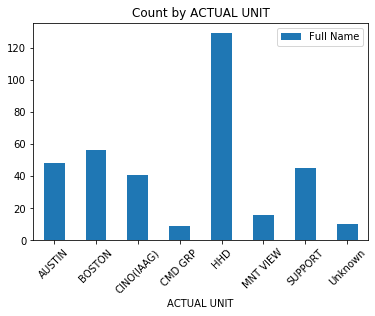

In [5]:
ax = count_unit.plot.bar(x='ACTUAL UNIT',y='Full Name', rot=0)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Count by ACTUAL UNIT')


In [6]:
print('Total Readiness Score Overall Stats:')
print(rp.summary_cont(metrics_frame['Total Readiness Score']))
print('Total Readiness Score Grouped by ACTUAL UNIT Stats:')
print(rp.summary_cont(metrics_frame['Total Readiness Score'].groupby(metrics_frame['ACTUAL UNIT'])))



Total Readiness Score Overall Stats:


                Variable      N       Mean         SD        SE  95% Conf.  \
0  Total Readiness Score  354.0  33.601271  22.714166  1.207244  31.226975   

    Interval  
0  35.975567  
Total Readiness Score Grouped by ACTUAL UNIT Stats:


               N       Mean         SD        SE  95% Conf.   Interval
ACTUAL UNIT                                                           
AUSTIN        48  41.362500  23.822586  3.438494  34.551733  48.173267
BOSTON        56  35.507143  26.370754  3.523940  28.537713  42.476573
CINO(IAAG)    41  32.363415  18.626980  2.909046  26.590854  38.135975
CMD GRP        9  26.200000  26.249143  8.749714   8.010272  44.389728
HHD          129  29.683721  21.716104  1.911996  25.921598  33.445844
MNT VIEW      16  43.518750  29.044477  7.261119  28.820217  58.217283
SUPPORT       45  30.866667  16.256244  2.423338  26.063254  35.670080
Unknown       10  44.385000  22.271781  7.042956  29.834103  58.935897


Text(0.5, 0.98, 'Total Readiness Score Distribution')

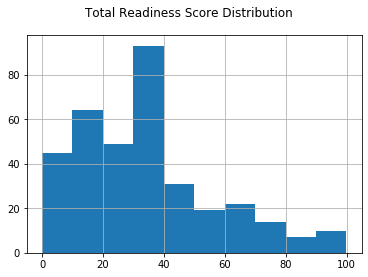

In [7]:
metrics_frame['Total Readiness Score'].hist()
pl.suptitle("Total Readiness Score Distribution")


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022348815308>,
      dtype=object)

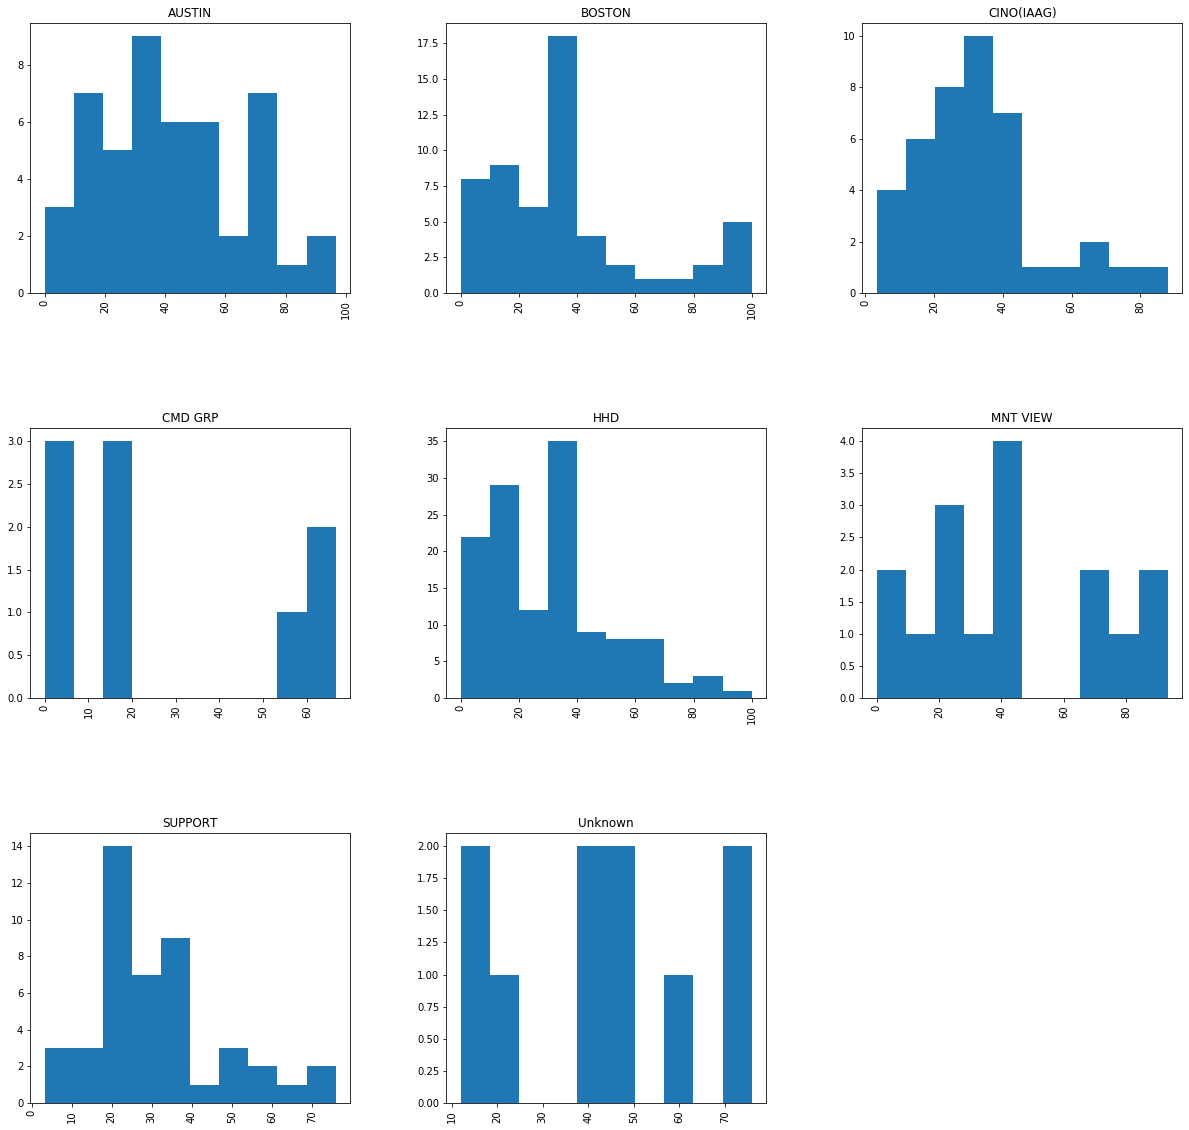

In [8]:
metrics_frame['Total Readiness Score'].hist(by=metrics_frame['ACTUAL UNIT'], 
                                           figsize=(20,20))
#plt.figure(figsize=(20,20))


In [9]:
def create_subsets(groupa, groupb):
    print('comparing %s and %s:' % (groupa, groupb))
    unit_loc_a = groupa
    unit_a_df = metrics_frame.loc[metrics_frame['ACTUAL UNIT'] == unit_loc_a]
    print('Group %s with average score %s and size %s' % (groupa, 
                                                          unit_a_df['Total Readiness Score'].mean(),
                                                          len(unit_a_df)))
    unit_loc_b = groupb
    unit_b_df = metrics_frame.loc[metrics_frame['ACTUAL UNIT'] == unit_loc_b]
    print('Group %s with average score %s and size %s' % (groupb, 
                                                          unit_b_df['Total Readiness Score'].mean(),
                                                          len(unit_b_df)))
    return unit_a_df, unit_b_df

In [10]:

def run_t_test(unit_a, unit_b):
    t2, p2 = stats.ttest_ind(unit_a['Total Readiness Score'], unit_b['Total Readiness Score'])
    print('T value: {}'.format(t2))
    print('P value: {}'.format(p2))
    return t2,p2

In [11]:
metrics_frame['ACTUAL UNIT'].unique()

array(['CMD GRP', 'HHD', 'Unknown', 'SUPPORT', 'CINO(IAAG)', 'MNT VIEW',
       'BOSTON', 'AUSTIN'], dtype=object)

In [12]:
t_list = []
p_list = []
group_list = []
group1_vals = []
group2_vals = []
group1_mean = []
group2_mean = []
group1_size = []
group2_size = []
group1_std = []
group2_std = []
combinations = list(it.combinations(metrics_frame['ACTUAL UNIT'].unique(),2))
for group1, group2 in combinations: 
    group1_df, group2_df = create_subsets(group1, group2)
    t, p = run_t_test(group1_df, group2_df)
    t_list.append(t)
    p_list.append(p)
    group_list.append((group1,group2)),
    group1_vals.append(group1),
    group2_vals.append(group2),
    group1_mean.append(group1_df['Total Readiness Score'].mean()),
    group2_mean.append(group2_df['Total Readiness Score'].mean()),
    group1_size.append(len(group1_df)),
    group2_size.append(len(group2_df)),
    group1_std.append(group1_df['Total Readiness Score'].std()),
    group2_std.append(group2_df['Total Readiness Score'].std())

comparing CMD GRP and HHD:
Group CMD GRP with average score 26.2 and size 9
Group HHD with average score 29.68372093023258 and size 129
T value: -0.45912107898110277
P value: 0.6468801886055227
comparing CMD GRP and Unknown:
Group CMD GRP with average score 26.2 and size 9
Group Unknown with average score 44.385 and size 10
T value: -1.633783986639706
P value: 0.12068573281449997
comparing CMD GRP and SUPPORT:
Group CMD GRP with average score 26.2 and size 9
Group SUPPORT with average score 30.866666666666653 and size 45
T value: -0.7039405061785858
P value: 0.48461031112557185
comparing CMD GRP and CINO(IAAG):
Group CMD GRP with average score 26.2 and size 9
Group CINO(IAAG) with average score 32.36341463414633 and size 41
T value: -0.8330542259027623
P value: 0.4089402434898416
comparing CMD GRP and MNT VIEW:
Group CMD GRP with average score 26.2 and size 9
Group MNT VIEW with average score 43.51875 and size 16
T value: -1.4789846586151494
P value: 0.1527109022389067
comparing CMD GR

In [13]:
t_test_frame = pd.DataFrame({'group':group_list,'t_value':t_list,'p_value':p_list,
                            'group1':group1_vals,'group1_size':group1_size,'group1_mean':group1_mean,
                            'group1_std':group1_std,'group2':group2_vals,'group2_size':group2_size,
                             'group2_mean':group2_mean, 'group2_std':group2_std,})

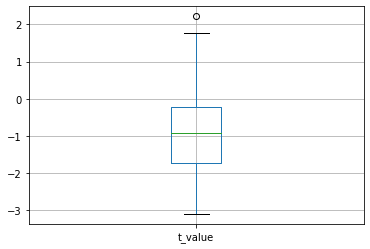

In [14]:
boxlot = t_test_frame.boxplot(column=(['t_value']))

In [15]:
#t_test_frame.to_csv(r'C:\Users\sarah\Documents\python\readiness_score_output\t_test_frame_CITY_SECTION.csv')

In [16]:
t_test_frame.head()

,group,t_value,p_value,group1,group1_size,group1_mean,group1_std,group2,group2_size,group2_mean,group2_std
0,"(CMD GRP, HHD)",-0.459121,0.646880,CMD GRP,9,26.2,26.249143,HHD,129,29.683721,21.716104
1,"(CMD GRP, Unknown)",-1.633784,0.120686,CMD GRP,9,26.2,26.249143,Unknown,10,44.385000,22.271781
2,"(CMD GRP, SUPPORT)",-0.703941,0.484610,CMD GRP,9,26.2,26.249143,SUPPORT,45,30.866667,16.256244
3,"(CMD GRP, CINO(IAAG))",-0.833054,0.408940,CMD GRP,9,26.2,26.249143,CINO(IAAG),41,32.363415,18.626980
4,"(CMD GRP, MNT VIEW)",-1.478985,0.152711,CMD GRP,9,26.2,26.249143,MNT VIEW,16,43.518750,29.044477


In [17]:
#metrics_frame['CITY/SECTION'].nunique()
metrics_frame['trs'] = metrics_frame['Total Readiness Score']
#metrics_frame['city_section'] = metrics_frame['CITY/SECTION']
metrics_frame['actual_unit'] = metrics_frame['ACTUAL UNIT']


### One Way ANOVA 

In [18]:
mod = ols('trs ~ actual_unit', data=metrics_frame).fit()

In [19]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    trs   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.481
Date:                Fri, 10 Apr 2020   Prob (F-statistic):             0.0170
Time:                        18:59:42   Log-Likelihood:                -1598.7
No. Observations:                 354   AIC:                             3213.
Df Residuals:                     346   BIC:                             3244.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    41.3625      3.231     12.800      0.000      35.007      47.718
actual_unit[T.BOSTON]        -5.8554      4.404     -1.330      0.185     -14.517       2.806
actual_unit[T.CINO(IAAG)]    -8.9991      4.761     -1.890      0.060     -18.363       0.365
actual_unit[T.CMD GRP]      -15.1625      8.132     -1.865      0.063     -31.157       0.832
actual_unit[T.HHD]          -11.6788      3.785     -3.085      0.002     -19.124      -4.234
actual_unit[T.MNT VIEW]       2.1563      6.463      0.334      0.739     -10.555      14.868
actual_unit[T.SUPPORT]      -10.4958      4.645     -2.259      0.024     -19.633      -1.359
actual_unit[T.Unknown]        3.0225      7.782      0.388      0.698     -12.284      18.329
==============================================================================
Omnibus:                       26.639   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.735
Skew:                           0.716   Prob(JB):                     2.12e-07
Kurtosis:                       3.184   Cond. No.                         9.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
aov_table = sm.stats.anova_lm(mod, type=2)

In [21]:
print(aov_table)

                df         sum_sq      mean_sq         F    PR(>F)
actual_unit    7.0    8703.496724  1243.356675  2.480677  0.016984
Residual     346.0  173420.975204   501.216691       NaN       NaN


In [22]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
actual_unit,8703.496724,7.0,1243.356675,2.480677,0.016984,0.047789,0.028446
Residual,173420.975204,346.0,501.216691,NaN,NaN,NaN,NaN


### Check ANOVA Assumptions

In [23]:
#when working with linear regression and ANOVA models, the assumptions pertain to the residuals 
#and not the variables themselves. 
#Using Statsmodels, we can use the diagnostics that is already provided
mod.diagn
#Jarque-Bera (jb; jbpv is p-value) tests the assumption of normality
#Omnibus (omni; omnipv is p-value) tests the assumption of homogeneity of variance
#Condition Number (condno) assess multicollinearity. 
#Condition Number values over 20 are indicative of multicollinearity.


{'jb': 30.734653160559805,
 'jbpv': 2.118628765482878e-07,
 'skew': 0.7158345595811055,
 'kurtosis': 3.184469055015475,
 'omni': 26.63926871586628,
 'omnipv': 1.641936273576124e-06,
 'condno': 9.727558847902122,
 'mineigval': 4.529686063439224}

In [24]:
# Homogeneity of Variance Check using Levene's
#Levene’s test for homogeneity of variance is not significant 
#which indicates that the groups have equal variances.
stats.levene(metrics_frame['Total Readiness Score'][metrics_frame['ACTUAL UNIT'] == 'BOSTON'],
             metrics_frame['Total Readiness Score'][metrics_frame['ACTUAL UNIT'] == 'CINO(IAAG)'],
             metrics_frame['Total Readiness Score'][metrics_frame['ACTUAL UNIT'] == 'CMD GRP'],
             metrics_frame['Total Readiness Score'][metrics_frame['ACTUAL UNIT'] == 'HHD'],
             metrics_frame['Total Readiness Score'][metrics_frame['ACTUAL UNIT'] == 'SUPPORT'],
             metrics_frame['Total Readiness Score'][metrics_frame['ACTUAL UNIT'] == 'MNT VIEW'],
             metrics_frame['Total Readiness Score'][metrics_frame['ACTUAL UNIT'] == 'AUSTIN'])

LeveneResult(statistic=2.070612509491373, pvalue=0.05616479840082893)

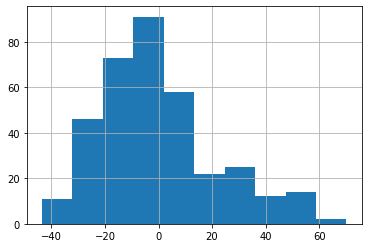

In [25]:
#sns.residplot(metrics_frame.actual_unit, metrics_frame.trs.astype('float'), lowess=True, color="g")
mod.resid.hist()

In [26]:
# Residual Normality check
#tested on the residuals as a whole which is how the diagnostic information provided by statsmodels tests
#the residuals. One could use the Jarque-Bera test provided, or one could use Shapiro or others.
stats.shapiro(mod.resid)


(0.958018958568573, 1.5843554024286277e-08)

## ANOVA Post-Hoc Analysis

### Tukey All pairwise comparison

In [27]:
mc = MultiComparison(metrics_frame['trs'],metrics_frame['actual_unit'])
tukey_result = mc.tukeyhsd(alpha=0.10)
print(tukey_result)
print('Unique actual_unit groups: {}'.format(mc.groupsunique))

     Multiple Comparison of Means - Tukey HSD, FWER=0.10     
  group1     group2   meandiff p-adj   lower    upper  reject
-------------------------------------------------------------
    AUSTIN     BOSTON  -5.8554 0.8831 -18.1554  6.4446  False
    AUSTIN CINO(IAAG)  -8.9991 0.5503 -22.2971  4.2989  False
    AUSTIN    CMD GRP -15.1625 0.5655 -37.8768  7.5518  False
    AUSTIN        HHD -11.6788 0.0451 -22.2512 -1.1064   True
    AUSTIN   MNT VIEW   2.1563    0.9 -15.8952 20.2077  False
    AUSTIN    SUPPORT -10.4958 0.3193 -23.4711  2.4795  False
    AUSTIN    Unknown   3.0225    0.9 -18.7143 24.7593  False
    BOSTON CINO(IAAG)  -3.1437    0.9 -15.9967  9.7092  False
    BOSTON    CMD GRP  -9.3071    0.9 -31.7638 13.1495  False
    BOSTON        HHD  -5.8234 0.7075 -15.8303  4.1835  False
    BOSTON   MNT VIEW   8.0116    0.9  -9.7146 25.7378  False
    BOSTON    SUPPORT  -4.6405    0.9 -17.1593  7.8783  False
    BOSTON    Unknown   8.8779    0.9 -12.5896 30.3453  False
CINO(IAA

### Dunnett's Method post hoc

### Hsus's Multiple comparisons to the best

### Unspervised Clustering 

* Feature correlation
* Silhoutte score calculation
* k means clustering
* cluster analysis

In [28]:
#metrics_frame.columns #return the columns available in the dataframe
feature_columns = ['ACTUAL UNIT','PHA Due.1', 'Dental Due.1', 'Eval Due.1', 'APFT Due.1', 'DD93 Due.1',
'SGLV Due.1', 'PRR Due.1', 'Medical Score', 'Eval Score',
'Soldier Skill Score', 'Admin Score', 'Total Readiness Score']


In [29]:
metrics_frame_subset = metrics_frame[feature_columns]

In [30]:
# raw metrics
corr = metrics_frame_subset.corr()
corr.style.background_gradient(cmap='coolwarm')


,PHA Due.1,Dental Due.1,Eval Due.1,APFT Due.1,DD93 Due.1,SGLV Due.1,PRR Due.1,Medical Score,Eval Score,Soldier Skill Score,Admin Score,Total Readiness Score
PHA Due.1,1,0.333223,0.0571154,0.114514,-0.0276531,0.0895757,0.0554389,0.832663,0.0571154,0.114514,0.0471434,0.636593
Dental Due.1,0.333223,1,0.0959331,0.217702,0.0146512,0.1287,0.0479135,0.799593,0.0959331,0.217702,0.0784116,0.661726
Eval Due.1,0.0571154,0.0959331,1,0.098611,0.0589629,0.125099,0.144751,0.0927255,1,0.098611,0.147186,0.608871
APFT Due.1,0.114514,0.217702,0.098611,1,0.0580765,0.144687,0.154791,0.200806,0.098611,1,0.158973,0.443711
DD93 Due.1,-0.0276531,0.0146512,0.0589629,0.0580765,1,0.275154,0.36093,-0.00900815,0.0589629,0.0580765,0.770071,0.146623
SGLV Due.1,0.0895757,0.1287,0.125099,0.144687,0.275154,1,0.274679,0.132646,0.125099,0.144687,0.6392,0.279033
PRR Due.1,0.0554389,0.0479135,0.144751,0.154791,0.36093,0.274679,1,0.0634534,0.144751,0.154791,0.77757,0.263209
Medical Score,0.832663,0.799593,0.0927255,0.200806,-0.00900815,0.132646,0.0634534,1,0.0927255,0.200806,0.0760827,0.794138
Eval Score,0.0571154,0.0959331,1,0.098611,0.0589629,0.125099,0.144751,0.0927255,1,0.098611,0.147186,0.608871
Soldier Skill Score,0.114514,0.217702,0.098611,1,0.0580765,0.144687,0.154791,0.200806,0.098611,1,0.158973,0.443711


In [31]:
metrics_frame_subset_grouped = metrics_frame_subset.groupby('ACTUAL UNIT')[['PHA Due.1', 'Dental Due.1', 'Eval Due.1', 'APFT Due.1', 'DD93 Due.1',
'SGLV Due.1', 'PRR Due.1', 'Medical Score', 'Eval Score',
'Soldier Skill Score', 'Admin Score', 'Total Readiness Score']].mean()

No handles with labels found to put in legend.


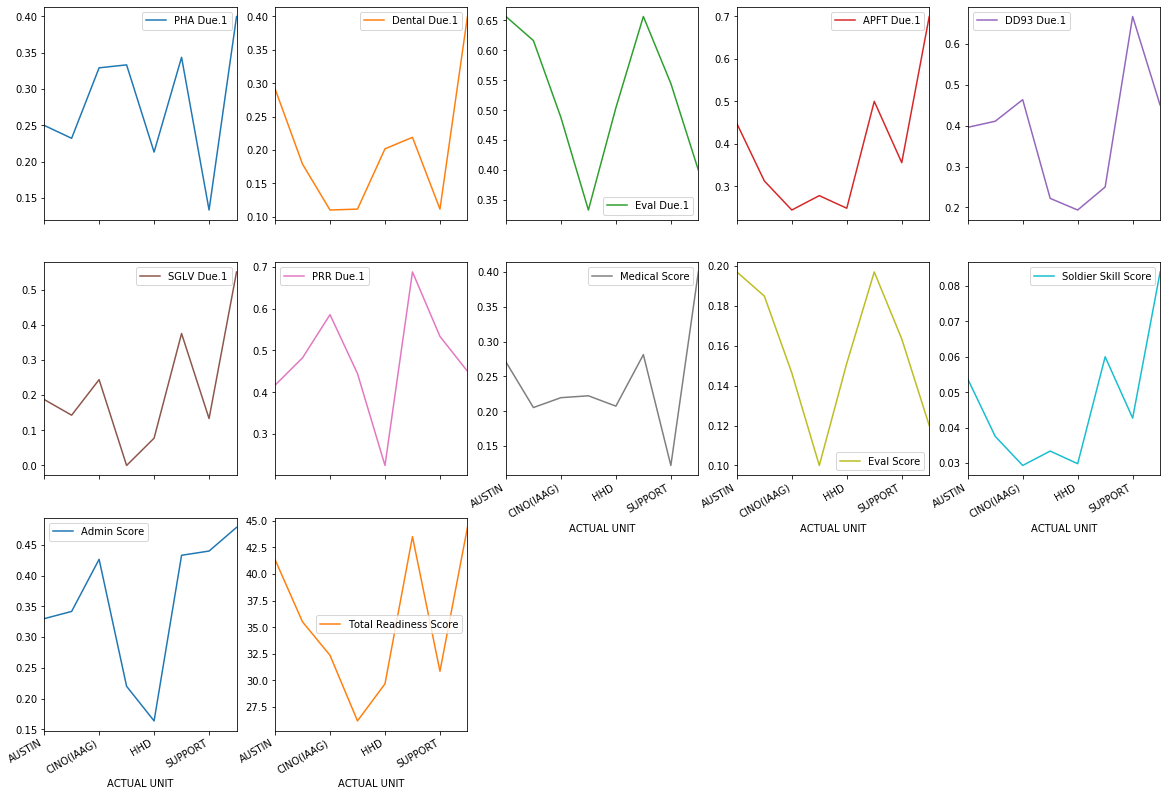

In [34]:
metrics_frame_subset_grouped.plot(subplots=True,layout=(4,5), figsize=(20,20))
#plt.tight_layout()
#plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [35]:

corr = metrics_frame_subset_grouped.corr()
corr.style.background_gradient(cmap='coolwarm')

,PHA Due.1,Dental Due.1,Eval Due.1,APFT Due.1,DD93 Due.1,SGLV Due.1,PRR Due.1,Medical Score,Eval Score,Soldier Skill Score,Admin Score,Total Readiness Score
PHA Due.1,1,0.437915,-0.396173,0.497148,-0.374953,0.614926,0.290632,0.820129,-0.396173,0.497148,0.259266,0.435815
Dental Due.1,0.437915,1,0.0732575,0.864513,-0.0620675,0.73626,-0.200354,0.873544,0.0732575,0.864513,0.270566,0.81077
Eval Due.1,-0.396173,0.0732575,1,0.0423849,0.121555,0.0716138,0.28808,-0.167871,1,0.0423849,0.206331,0.467081
APFT Due.1,0.497148,0.864513,0.0423849,1,0.163001,0.867186,0.219068,0.819384,0.0423849,1,0.606668,0.857007
DD93 Due.1,-0.374953,-0.0620675,0.121555,0.163001,1,0.199929,0.318189,-0.242509,0.121555,0.163001,0.686058,0.0842246
SGLV Due.1,0.614926,0.73626,0.0716138,0.867186,0.199929,1,0.396948,0.801524,0.0716138,0.867186,0.762136,0.851153
PRR Due.1,0.290632,-0.200354,0.28808,0.219068,0.318189,0.396948,1,0.0298385,0.28808,0.219068,0.744966,0.348253
Medical Score,0.820129,0.873544,-0.167871,0.819384,-0.242509,0.801524,0.0298385,1,-0.167871,0.819384,0.312573,0.751972
Eval Score,-0.396173,0.0732575,1,0.0423849,0.121555,0.0716138,0.28808,-0.167871,1,0.0423849,0.206331,0.467081
Soldier Skill Score,0.497148,0.864513,0.0423849,1,0.163001,0.867186,0.219068,0.819384,0.0423849,1,0.606668,0.857007


In [36]:
x = StandardScaler().fit_transform(metrics_frame_subset_grouped[metrics_frame_subset_grouped.columns[1:]])

In [40]:
range_n_clusters = list (range(2,7))
print ("Number of clusters from 2 to 9: \n", range_n_clusters)
silhouette_score_values=list()

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(metrics_frame_subset_grouped[metrics_frame_subset_grouped.columns[1:]])
    centers = clusterer.cluster_centers_

    score = silhouette_score(metrics_frame_subset_grouped[metrics_frame_subset_grouped.columns[1:]], preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    silhouette_score_values.append(silhouette_score(metrics_frame_subset_grouped[metrics_frame_subset_grouped.columns[1:]], preds,metric='euclidean', sample_size=None, random_state=None))



Number of clusters from 2 to 9: 
 [2, 3, 4, 5, 6]
For n_clusters = 2, silhouette score is 0.6932844343266098)
For n_clusters = 3, silhouette score is 0.46584298368309784)
For n_clusters = 4, silhouette score is 0.44394865961047)
For n_clusters = 5, silhouette score is 0.32928087478650153)
For n_clusters = 6, silhouette score is 0.22783019187546935)


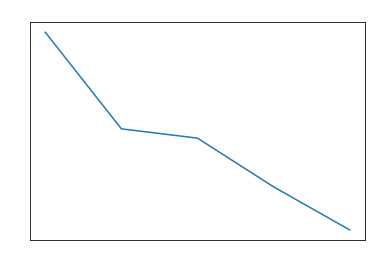

Optimal number of components is:
2


In [46]:
#plt.plot(range_n_clusters, silhouette_score_values)
plt.clf()
title_obj =plt.title("Silhouette score values vs Numbers of Clusters ")
plt.setp(title_obj , color='w')         #set the color of title to white
#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax = fig.add_subplot(111)
#ax.set_xlabel('n-clusters')
#ax.set_ylabel('Silhouette Score')
plt.rc_context({'ytick.color':'white','xtick.color':'white'})
#ax.xaxis.label.set_color('white')
#ax.yaxis.label.set_color('white')

#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
plt.plot(range_n_clusters, silhouette_score_values)

plt.show()
Optimal_NumberOf_Components=range_n_clusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)

In [48]:
clusterer = KMeans(n_clusters=Optimal_NumberOf_Components)
preds = clusterer.fit_predict(metrics_frame_subset_grouped[metrics_frame_subset_grouped.columns[1:]])
metrics_frame_subset_grouped['cluster'] = preds

In [51]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

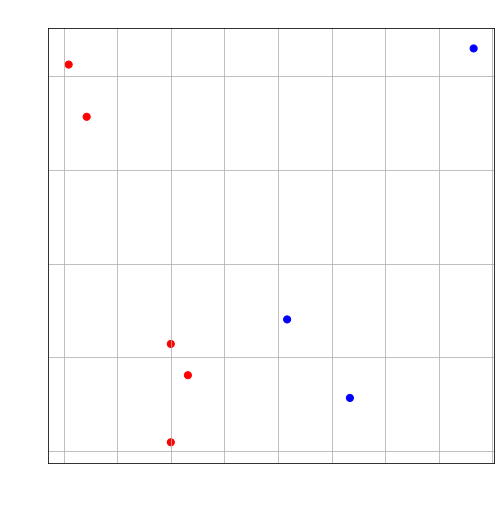

In [54]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
#colors = ['r', 'g', 'b','y']
#for target, color in zip(targets,colors):
#indicesToKeep = finalDf['week'] == target
#finalDf.loc[finalDf.week, 'principal component 1']
            #   , finalDf.loc[finalDf.week, 'principal component 2']

LABEL_COLOR_MAP = {0 : 'r',
               1 : 'b',
               2:'g',
               3:'y'
               }

label_color = [LABEL_COLOR_MAP[l] for l in metrics_frame_subset_grouped.cluster]
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.scatter(principalDf['principal component 1']
               ,principalDf['principal component 2']
               , s = 50, c=label_color)
#ax.legend(targets)
ax.grid()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002234B065848>,
      dtype=object)

<Figure size 1440x1440 with 0 Axes>

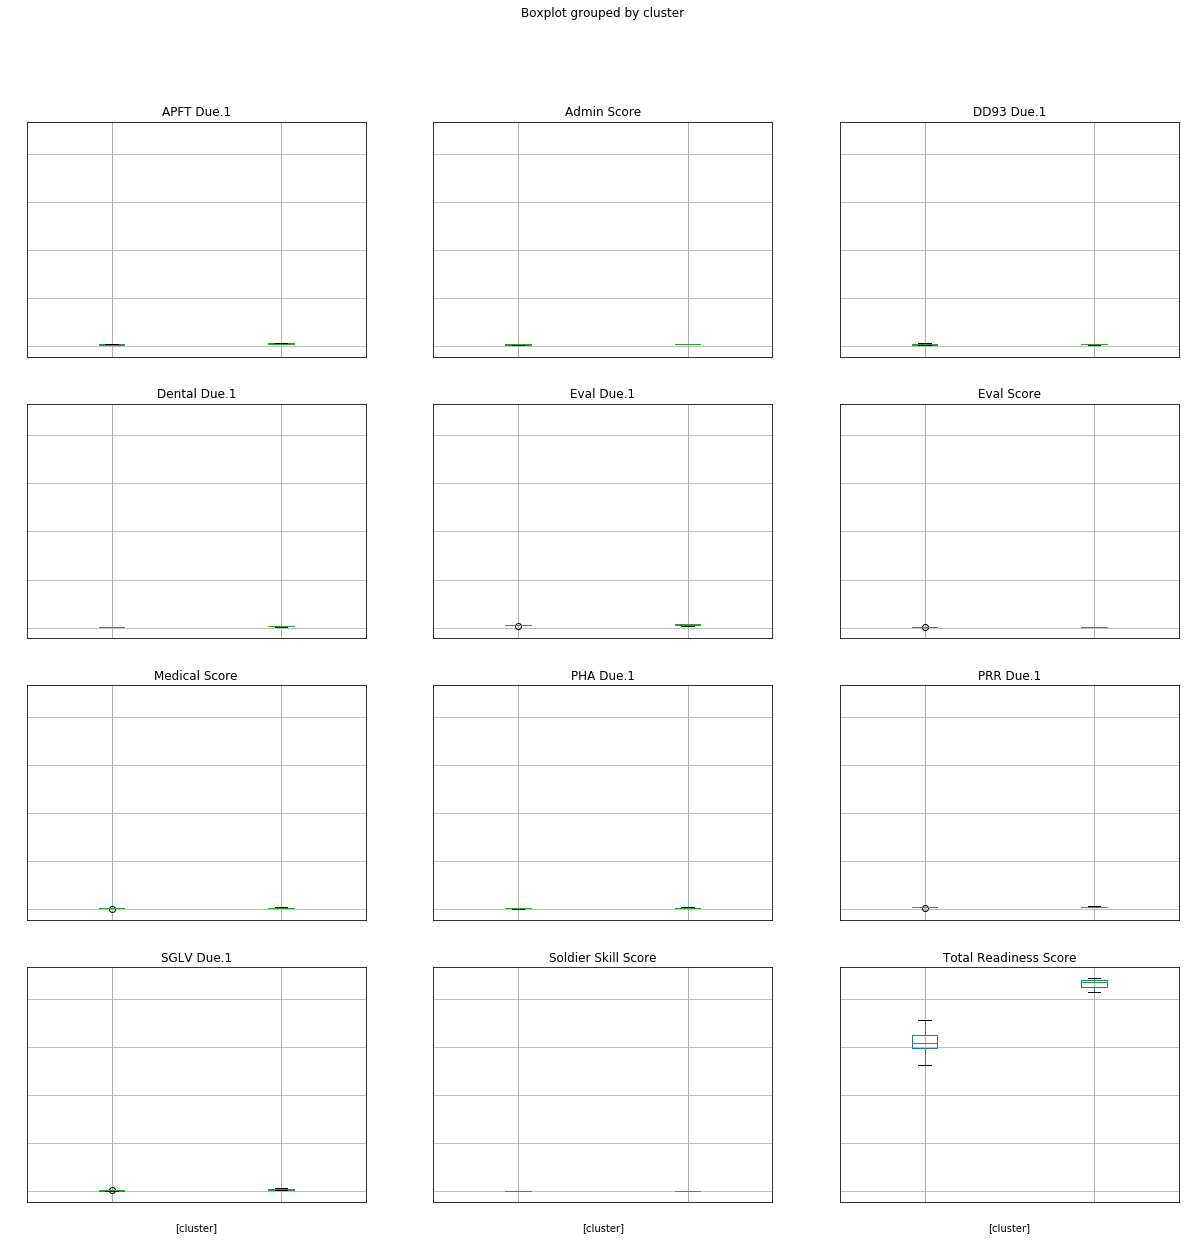

In [57]:
#fig = plt.figure(figsize = (20,20))
metrics_frame_subset_grouped.boxplot(by='cluster', figsize=(20,20))
